# Load Dataset

In [1]:
!pip install kagglehub

  Using cached kagglehub-0.3.13-py3-none-any.whl.metadata (38 kB)
Using cached kagglehub-0.3.13-py3-none-any.whl (68 kB)


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shanegerami/ai-vs-human-text")

print("Path to dataset files:", path)

Path to dataset files: /home/sagemaker-user/.cache/kagglehub/datasets/shanegerami/ai-vs-human-text/versions/1


In [3]:
import pandas as pd
import os

file_path = os.path.join(path, 'AI_Human.csv')

df = pd.read_csv(file_path)

df.head()

# 0 -> Human
# 1 -> AI

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0


# EDA

In [4]:
df = df.rename(columns={'generated': 'labels'})

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from sklearn.model_selection import train_test_split

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Dataset basic info

In [6]:
print("\n--- Basic info ---")
df.info()

print("\n--- Missing value detection ---")
print(df.isnull().sum())

print("\n--- Duplicate value detection ---")
print(f"Duplicate number: {df.duplicated().sum()}")


--- Basic info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487235 entries, 0 to 487234
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   text    487235 non-null  object 
 1   labels  487235 non-null  float64
dtypes: float64(1), object(1)
memory usage: 7.4+ MB

--- Missing value detection ---
text      0
labels    0
dtype: int64

--- Duplicate value detection ---
Duplicate number: 0


In [7]:
label_col = 'labels'

print("\n--- Category Statistics ---")
print(df[label_col].value_counts())


--- Category Statistics ---
labels
0.0    305797
1.0    181438
Name: count, dtype: int64


Label Distribution

/tmp/ipykernel_1875/607896369.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=label_col, palette="coolwarm")


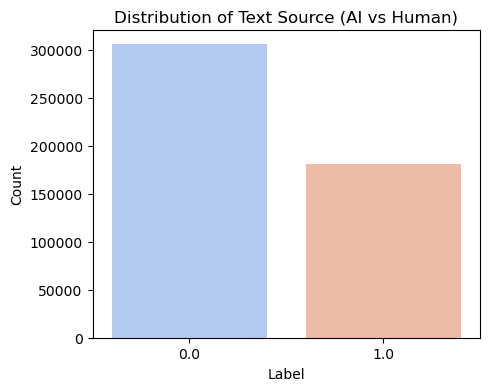

In [8]:
plt.figure(figsize=(5,4))
sns.countplot(data=df, x=label_col, palette="coolwarm")
plt.title("Distribution of Text Source (AI vs Human)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

Text Length Distribution


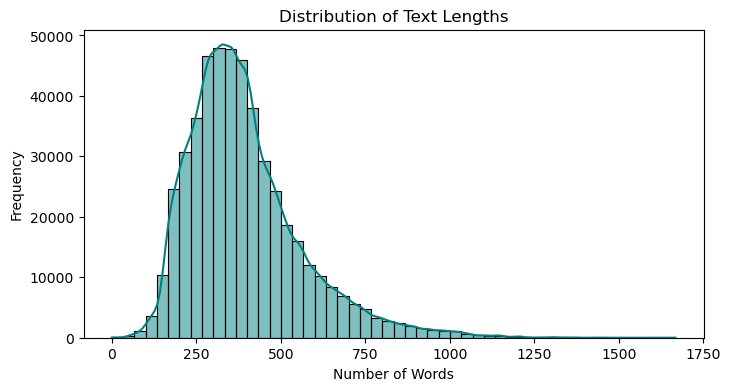


Average text length: 393.1
Maximum text length: 1668


In [9]:
text_col = 'text'
df['text_length'] = df[text_col].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(8,4))
sns.histplot(df['text_length'], bins=50, kde=True, color='teal')
plt.title("Distribution of Text Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

print("\nAverage text length:", round(df['text_length'].mean(), 2))
print("Maximum text length:", df['text_length'].max())

In [10]:
print(df.groupby(label_col)['text_length'].describe())

           count       mean         std   min    25%    50%    75%     max
labels                                                                    
0.0     305797.0  421.98518  186.870962  14.0  281.0  389.0  520.0  1668.0
1.0     181438.0  344.40653  117.031491   0.0  274.0  337.0  403.0  1238.0


# Preprocessing

In [11]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"[^a-zA-Z\s]", '', text)
    text = re.sub(r"\s+", ' ', text).strip()
    tokens = [word for word in text.split() if word not in stop_words]
    return " ".join(tokens)

df['clean_text'] = df[text_col].apply(clean_text)

# print("\n原始文本示例:\n", df[text_col].iloc[0])
# print("\n清洗后文本示例:\n", df['clean_text'].iloc[0])

# Data split


--- Results of dataset split ---
train: (341064, 4), val: (73085, 4), test: (73086, 4)


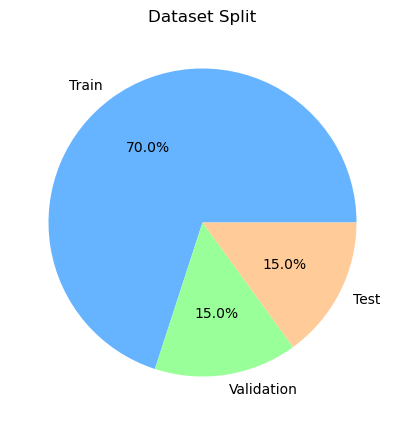

In [12]:
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df[label_col])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df[label_col])

print("\n--- Results of dataset split ---")
print(f"train: {train_df.shape}, val: {val_df.shape}, test: {test_df.shape}")

sizes = [len(train_df), len(val_df), len(test_df)]
labels = ['Train', 'Validation', 'Test']
plt.figure(figsize=(5,5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['#66b3ff','#99ff99','#ffcc99'])
plt.title("Dataset Split")
plt.show()

# Model

In [13]:
!pip install -q transformers datasets evaluate accelerate

import pandas as pd
import numpy as np
import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
import evaluate
from sklearn.metrics import classification_report

2025-10-20 13:25:26.005493: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-20 13:25:26.192860: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760966726.219681    1875 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760966726.232343    1875 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-20 13:25:26.437922: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [14]:
train_ds = Dataset.from_pandas(train_df[['clean_text','labels']])
val_ds = Dataset.from_pandas(val_df[['clean_text','labels']])
test_ds = Dataset.from_pandas(test_df[['clean_text','labels']])

Define Evaluation Metrics

In [15]:
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)['accuracy'],
        "f1": f1.compute(predictions=preds, references=labels, average='macro')['f1']
    }

Define Train function

In [16]:
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_names = {
    "bert": "bert-base-uncased",
    "deberta": "microsoft/deberta-v3-base",
    "DistilBERT": "distilbert-base-uncased",
    "MiniDeBERTa": "microsoft/deberta-v3-small"
}

num_labels = 2
num_epochs = 7
batch_size = 16
learning_rate = 2e-5

In [17]:
train_dataset_small = train_ds.shuffle(seed=42).select(range(int(0.01 * len(train_ds))))
val_dataset_small = val_ds.shuffle(seed=42).select(range(int(0.01 * len(val_ds))))
print(f"use {len(train_dataset_small)} train samples and {len(val_dataset_small)} val samples")
train_loader = DataLoader(train_dataset_small, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset_small, batch_size=batch_size)

use 3410 train samples and 730 val samples


In [18]:
def train_model(model_name):
    print(f"\n===== Training {model_name} =====")
    tokenizer = AutoTokenizer.from_pretrained(model_names[model_name])
    model = AutoModelForSequenceClassification.from_pretrained(model_names[model_name], num_labels=num_labels).to(device)

    optimizer = AdamW(model.parameters(), lr=learning_rate)
    total_steps = len(train_loader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss, total_train_acc = 0, 0
        for batch in train_loader:
            # Tokenize the text data
            inputs = tokenizer(batch['clean_text'], padding=True, truncation=True, return_tensors="pt").to(device)
            # Ensure labels are of type torch.long
            inputs['labels'] = batch['labels'].long().to(device)

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = outputs.loss
            logits = outputs.logits
            loss.backward()
            optimizer.step()
            scheduler.step()

            total_train_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            total_train_acc += accuracy_score(inputs["labels"].cpu(), preds.cpu())

        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_acc = total_train_acc / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accs.append(avg_train_acc)

        model.eval()
        total_val_loss, total_val_acc = 0, 0
        with torch.no_grad():
            for batch in val_loader:
                # Tokenize the text data
                inputs = tokenizer(batch['clean_text'], padding=True, truncation=True, return_tensors="pt").to(device)
                # Ensure labels are of type torch.long
                inputs['labels'] = batch['labels'].long().to(device)

                outputs = model(**inputs)
                loss = outputs.loss
                logits = outputs.logits

                total_val_loss += loss.item()
                preds = torch.argmax(logits, dim=1)
                total_val_acc += accuracy_score(inputs["labels"].cpu(), preds.cpu())

        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_acc = total_val_acc / len(val_loader)
        val_losses.append(avg_val_loss)
        val_accs.append(avg_val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
              f"Train Acc: {avg_train_acc:.4f} | Val Acc: {avg_val_acc:.4f}")

    if num_epochs > 0: # Check if there is data to plot
        epochs = range(1, num_epochs + 1)
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        if num_epochs == 1: # Plot as points for a single epoch
            plt.plot(epochs, train_losses, 'bo', label='Train Loss')
            plt.plot(epochs, val_losses, 'ro', label='Val Loss')
        else: # Plot as lines for multiple epochs
            plt.plot(epochs, train_losses, 'b-', label='Train Loss')
            plt.plot(epochs, val_losses, 'r-', label='Val Loss')
        plt.title(f'{model_name.upper()} Loss vs Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        if num_epochs == 1: # Plot as points for a single epoch
            plt.plot(epochs, train_accs, 'bo', label='Train Acc')
            plt.plot(epochs, val_accs, 'ro', label='Val Acc')
        else: # Plot as lines for multiple epochs
            plt.plot(epochs, train_accs, 'b-', label='Train Acc')
            plt.plot(epochs, val_accs, 'r-', label='Val Acc')
        plt.title(f'{model_name.upper()} Accuracy vs Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.tight_layout()
        plt.show()
        plt.close() # Close the plot after showing
    """
    return {
        "train_loss": train_losses,
        "val_loss": val_losses,
        "train_acc": train_accs,
        "val_acc": val_accs,
    }
    """
    return model

# Train & Evaluate


===== Training bert =====


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7 | Train Loss: 0.2884 | Val Loss: 0.1184 | Train Acc: 0.8881 | Val Acc: 0.9611
Epoch 2/7 | Train Loss: 0.0845 | Val Loss: 0.0816 | Train Acc: 0.9717 | Val Acc: 0.9783
Epoch 3/7 | Train Loss: 0.0419 | Val Loss: 0.1025 | Train Acc: 0.9871 | Val Acc: 0.9701
Epoch 4/7 | Train Loss: 0.0265 | Val Loss: 0.0881 | Train Acc: 0.9939 | Val Acc: 0.9742
Epoch 5/7 | Train Loss: 0.0144 | Val Loss: 0.0922 | Train Acc: 0.9965 | Val Acc: 0.9769
Epoch 6/7 | Train Loss: 0.0095 | Val Loss: 0.0630 | Train Acc: 0.9985 | Val Acc: 0.9837
Epoch 7/7 | Train Loss: 0.0082 | Val Loss: 0.1029 | Train Acc: 0.9985 | Val Acc: 0.9755


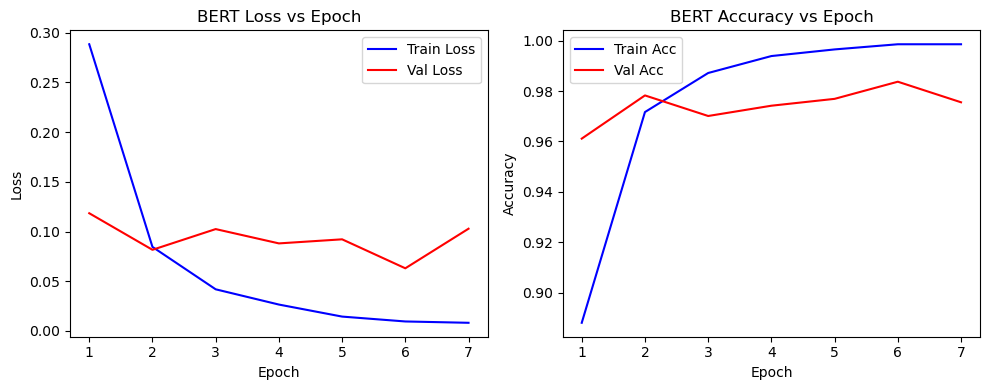

In [19]:
# bert_result = train_model("DistilBERT")
# bert_model = bert_result["model"]
bert_model = train_model("bert")

In [20]:
# deberta_result = train_model("MiniDeBERTa")

# Test

In [21]:
test_dataset_small = test_ds.shuffle(seed=42).select(range(int(0.01 * len(val_ds))))
test_loader = DataLoader(test_dataset_small, batch_size=batch_size)

def evaluate_model(model, test_loader, tokenizer):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in test_loader:
            inputs = tokenizer(batch['clean_text'], padding=True, truncation=True, return_tensors="pt").to(device)
            labels = batch['labels'].long().to(device)

            outputs = model(**inputs)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\n===== Evaluation on Test Set =====")
    print(classification_report(all_labels, all_preds))

    return classification_report(all_labels, all_preds, output_dict=True)

In [22]:
# Assuming 'bert_model' and 'bert_result' are available from the previous training step
# If you trained a different model, replace 'bert_model' and 'bert_result' with the variables holding that model and its results.
distilbert_test_report = evaluate_model(bert_model, test_loader, AutoTokenizer.from_pretrained(model_names["DistilBERT"]))


===== Evaluation on Test Set =====
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       444
           1       0.97      0.99      0.98       286

    accuracy                           0.98       730
   macro avg       0.98      0.98      0.98       730
weighted avg       0.98      0.98      0.98       730



In [23]:
# Assuming 'bert_model' is your trained model object
# Create a directory to save the model
output_dir = "./distilbert_finetuned"
import os
os.makedirs(output_dir, exist_ok=True)

# Save the model and tokenizer
bert_model.save_pretrained(output_dir)

print(f"Model saved to {output_dir}")

Model saved to ./distilbert_finetuned
